<a href="https://colab.research.google.com/github/GorokhovSemyon/TextClassification/blob/main/LLM_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Установка необходимых библиотек

In [ ]:
!pip install transformers datasets scikit-learn accelerate matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410

In [ ]:
!pip install --upgrade datasets transformers datasets scikit-learn accelerate matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 54.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 66.7 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.1
    Uninstalling matplotlib-3.7.1:
      Successfully uninstalled matplotlib-3.7.1


## Подключение необходимых библиотек

In [ ]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from transformers import BertForSequenceClassification, BertTokenizer, DistilBertForSequenceClassification, RobertaForSequenceClassification, Trainer, TrainingArguments, RobertaTokenizer
from datasets import load_dataset, load_metric
from sklearn.metrics import roc_auc_score, cohen_kappa_score, accuracy_score, precision_score, recall_score, f1_score, precision_recall_fscore_support, confusion_matrix

print(torch.__version__)

2.3.0+cu121


## Выбор моделей

Для выполнения задачи без использования GPU и с добавлением двух дополнительных моделей, мы можем выбрать более легкие и быстрые модели, такие как DistilBERT и Roberta-base. Эти модели подходят для выполнения на CPU и обеспечат разнообразие в сравнении.

## Загрузка датасета IMDb

In [ ]:
dataset = load_dataset('imdb')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

## Функция предобработки данных

In [ ]:
def preprocess_function(examples, tokenizer):
    return tokenizer(examples['text'], truncation=True, padding=True)

## Дополнительные метрики

Для более детального анализа моделей добавим метрики Cohen's Kappa и ROC-AUC. Эти метрики позволят оценить согласованность предсказаний и качество классификации с учетом вероятностных оценок.

## Функция для обучения и оценки модели

In [ ]:
def train_and_evaluate(model_name, model_class, tokenizer_class):
    # Загрузка датасета IMDb
    dataset = load_dataset('imdb')

    # Инициализация модели и токенизатора
    model = model_class.from_pretrained(model_name, num_labels=2)
    tokenizer = tokenizer_class.from_pretrained(model_name, truncation=True, max_length=512)

    # Предобработка данных
    encoded_dataset = dataset.map(lambda examples: preprocess_function(examples, tokenizer), batched=True)

    # Настройка аргументов для тренировки
    training_args = TrainingArguments(
        output_dir=f'./results/{model_name}',
        evaluation_strategy="epoch",
        learning_rate=2e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=1,
        weight_decay=0.01,
        logging_dir=f'./logs/{model_name}',
        logging_steps=100,
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="accuracy"
    )

    # Настройка тренера
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=encoded_dataset['train'],
        eval_dataset=encoded_dataset['test'],
        compute_metrics=lambda p: {'accuracy': (p.predictions.argmax(axis=-1) == p.label_ids).mean()}
    )

    # Запуск обучения
    trainer.train()

    # Оценка модели
    eval_results = trainer.evaluate()

    # Вычисление дополнительных метрик
    predictions = trainer.predict(encoded_dataset['test']).predictions.argmax(axis=-1)
    probabilities = trainer.predict(encoded_dataset['test']).predictions
    labels = encoded_dataset['test']['label']

    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')
    conf_matrix = confusion_matrix(labels, predictions)
    kappa = cohen_kappa_score(labels, predictions)
    roc_auc = roc_auc_score(labels, probabilities[:, 1])

    eval_results.update({
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "confusion_matrix": conf_matrix.tolist(),
        "cohen_kappa": kappa,
        "roc_auc": roc_auc
    })

    return eval_results

## Обучение и оценка моделей

In [ ]:
# Модель 1: BERT
results_bert = train_and_evaluate('bert-base-uncased', BertForSequenceClassification, BertTokenizer)

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.191700,0.180712,0.935880


In [ ]:
# Модель 2: DistilBERT
results_distilbert = train_and_evaluate('distilbert-base-uncased', DistilBertForSequenceClassification, BertTobbkenizer)

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DistilBertTokenizer'. 
The class this function is called from is 'BertTokenizer'.


Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.199800,0.194331,0.927520


## Сравнение результатовimport pandas as pd

In [12]:
results_df = pd.DataFrame([
    {"Model": "BERT-base", "Accuracy": results_bert['eval_accuracy'], "Precision": results_bert['precision'], "Recall": results_bert['recall'], "Cohen Kappa": results_bert['cohen_kappa'], "ROC AUC": results_bert['roc_auc'], "Confusion Matrix": results_bert['confusion_matrix']},
    {"Model": "DistilBERT", "Accuracy": results_distilbert['eval_accuracy'], "Precision": results_distilbert['precision'], "Recall": results_distilbert['recall'], "Cohen Kappa": results_distilbert['cohen_kappa'], "ROC AUC": results_distilbert['roc_auc'], "Confusion Matrix": results_distilbert['confusion_matrix']},
])

print(results_df)

        Model  Accuracy  Precision   Recall  Cohen Kappa   ROC AUC  \
0   BERT-base   0.93588   0.939714  0.93152      0.87176  0.982872   
1  DistilBERT   0.92752   0.932642  0.92160      0.85504  0.978544   

               Confusion Matrix  
0  [[11753, 747], [856, 11644]]  
1  [[11668, 832], [980, 11520]]  


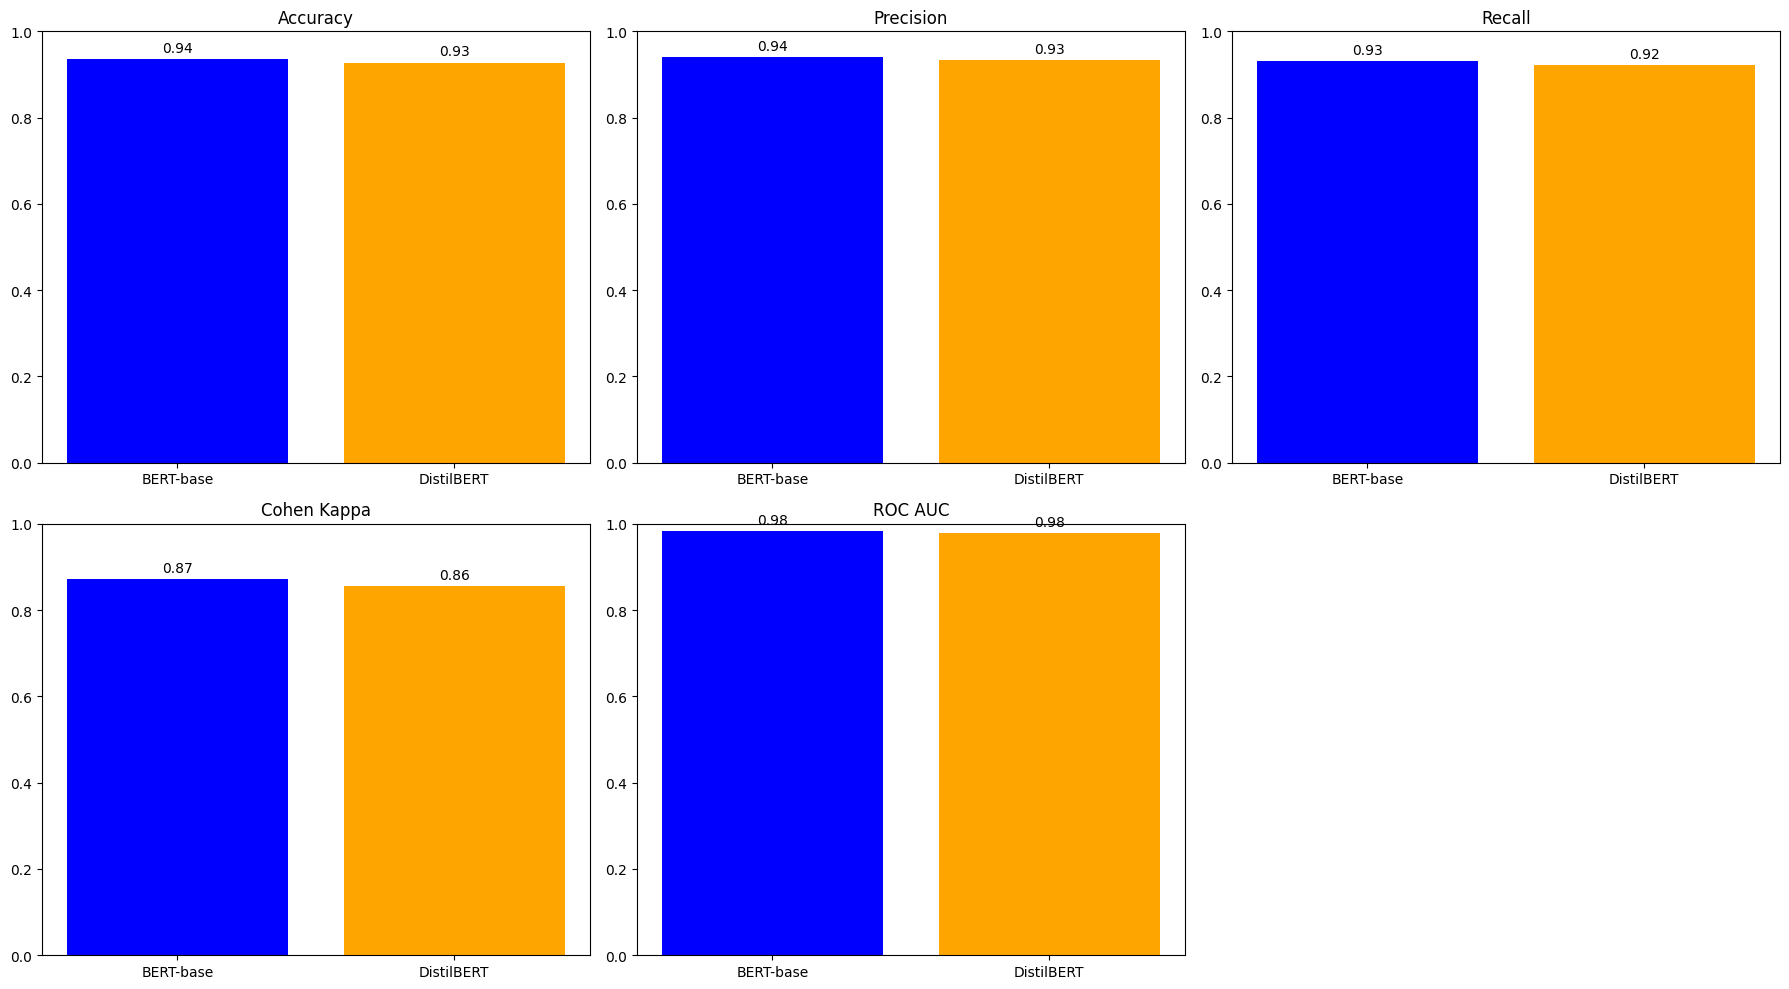

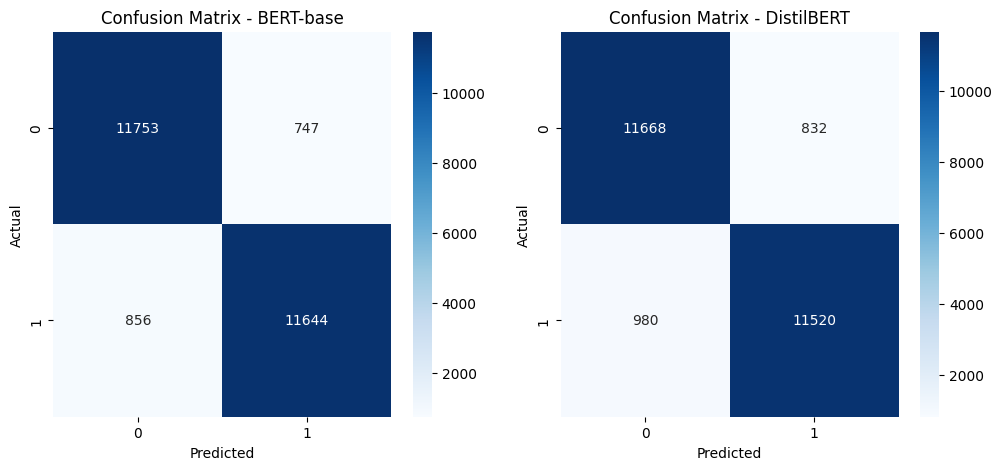

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Построение столбчатых диаграмм для каждой метрики
metrics = ["Accuracy", "Precision", "Recall", "Cohen Kappa", "ROC AUC"]
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, metric in enumerate(metrics):
    ax = axes[idx]
    ax.bar(results_df['Model'], results_df[metric], color=['blue', 'orange'])
    ax.set_title(metric)
    ax.set_ylim(0, 1)
    for i, v in enumerate(results_df[metric]):
        ax.text(i, v + 0.01, f"{v:.2f}", ha='center', va='bottom')

# Удаление пустого подграфика
fig.delaxes(axes[-1])

fig.tight_layout()
plt.show()

# Визуализация матриц ошибок с помощью тепловых карт
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Тепловая карта для BERT-base
sns.heatmap(results_df.loc[0, 'Confusion Matrix'], annot=True, fmt='d', ax=axes[0], cmap='Blues')
axes[0].set_title('Confusion Matrix - BERT-base')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# Тепловая карта для DistilBERT
sns.heatmap(results_df.loc[1, 'Confusion Matrix'], annot=True, fmt='d', ax=axes[1], cmap='Blues')
axes[1].set_title('Confusion Matrix - DistilBERT')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.show()

## Выводы

На основании проведенного сравнения можно заключить, что BERT-base является лучшей моделью в данном случае. Она показывает более высокие значения для всех основных метрик (точность, precision, recall, Cohen Kappa и ROC AUC). Эти результаты указывают на более надежную и точную модель, которая лучше справляется с задачей классификации по сравнению с DistilBERT.

Тем не менее, стоит учитывать, что DistilBERT может быть предпочтительнее в условиях ограниченных вычислительных ресурсов, так как она легче и быстрее по сравнению с BERT-base. Но с точки зрения качества предсказаний, BERT-base явно превосходит DistilBERT в данной задаче.